<a href="https://colab.research.google.com/github/AnahVeronica/RANZCR_CLiP_Catheter_and_Line_Position_Challenge/blob/main/RANZCR_CLiP_Catheter_and_Line_Position_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary files

In [ ]:
#Mount drive to access train and test tfrecords

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import io
from PIL import Image
import tensorflow as tf
from IPython import display
import cv2 as cv

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [ ]:
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# Step 1: Get dataset from directory

In [ ]:
Train_folder_path = '/content/drive/MyDrive/train_tfrecords'

In [ ]:
TFRecord_filenames = []

In [ ]:
for dirpath, dirnames, files in os.walk(Train_folder_path):
  for filename in files:
    TFRecord_filenames.append(os.path.join(dirpath, filename))



In [ ]:
dataset_size = 30083

train_size = int(0.8 * dataset_size)
val_size = int(0.2 * dataset_size)

# Create a training and a validation datasets
full_dataset = tf.data.TFRecordDataset(TFRecord_filenames)
full_dataset = full_dataset.shuffle(buffer_size=1000)
train_dataset = full_dataset.take(train_size) #.cache()
val_dataset = full_dataset.skip(train_size).take(val_size)

#Step 2:Write functions to parse tfrecord

In [ ]:
feature_dictionary = {
    'CVC - Abnormal': tf.io.FixedLenFeature([], tf.int64),
    'CVC - Borderline': tf.io.FixedLenFeature([], tf.int64),
    'CVC - Normal': tf.io.FixedLenFeature([], tf.int64),
    'ETT - Abnormal': tf.io.FixedLenFeature([], tf.int64),
    'ETT - Borderline': tf.io.FixedLenFeature([], tf.int64),
    'ETT - Normal': tf.io.FixedLenFeature([], tf.int64),
    'NGT - Abnormal': tf.io.FixedLenFeature([], tf.int64),
    'NGT - Borderline': tf.io.FixedLenFeature([], tf.int64),
    'NGT - Incompletely Imaged': tf.io.FixedLenFeature([], tf.int64),
    'NGT - Normal': tf.io.FixedLenFeature([], tf.int64),
    'StudyInstanceUID': tf.io.FixedLenFeature([], tf.string),    
    'Swan Ganz Catheter Present': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string),
}

In [ ]:
target_size_dim = 300
# Define two parsing functions that will turn the TFRecord back into an array and a label        
def _parse_function(example, feature_dictionary=feature_dictionary):
    # Parse the input `tf.train.Example` proto using the feature_dictionary.
    # Create a description of the features.
    parsed_example = tf.io.parse_example(example, feature_dictionary)

    CVC_Abnormal = tf.cast(parsed_example['CVC - Abnormal'], tf.int64)
    CVC_Borderline = tf.cast(parsed_example['CVC - Borderline'], tf.int64)
    CVC_Normal = tf.cast(parsed_example['CVC - Normal'], tf.int64)
    ETT_Abnormal = tf.cast(parsed_example['ETT - Abnormal'], tf.int64)
    ETT_Borderline = tf.cast(parsed_example['ETT - Borderline'], tf.int64)
    ETT_Normal = tf.cast(parsed_example['ETT - Normal'], tf.int64)
    NGT_Abnormal = tf.cast(parsed_example['NGT - Abnormal'], tf.int64)
    NGT_Borderline = tf.cast(parsed_example['NGT - Borderline'], tf.int64)
    NGT_Incompletely_Imaged = tf.cast(parsed_example['NGT - Incompletely Imaged'], tf.int64)
    NGT_Normal = tf.cast(parsed_example['NGT - Normal'], tf.int64)
    SGC_present = tf.cast(parsed_example['Swan Ganz Catheter Present'], tf.int64)
    #Image = tf.cast(parsed_example['image'], tf.string)


    features =  tf.io.decode_image(parsed_example['image'], expand_animations = False)
    features =  tf.image.grayscale_to_rgb(features)
    features =  tf.image.random_brightness(features, 0.3)
    features =  tf.image.random_flip_left_right(features)
    features =  tf.image.resize(features,size=(target_size_dim, target_size_dim))
    #features = features/255
    #features = features - tf.math.reduce_mean(features, axis= 0)

    label = [CVC_Normal + CVC_Abnormal  + CVC_Borderline]
    return features, label



In [ ]:
def _clahe_preprocess(image, labels):
  clahe = cv.createCLAHE(clipLimit=15.0, tileGridSize=(8,8))
  img = image.numpy()
  img = np.uint8(img)
  lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)
  lab_planes = cv.split(lab)
  lab_planes[0] = clahe.apply(lab_planes[0])
  lab = cv.merge(lab_planes)
  img = cv.cvtColor(lab, cv.COLOR_LAB2BGR)

  img = img/255
  return img, labels

#Step 3: Create a data loader

In [ ]:
def data_loader(train_data):
  dataset = train_data.map(_parse_function)
  dataset = dataset.map(lambda image,label: tf.py_function(func=_clahe_preprocess,
                                                      inp=[image,label],
                                                      Tout=[np.float32,tf.int64]))
  return dataset

# Load data and view image

In [ ]:
def get_dataset(filenames):
    dataset = data_loader(filenames)
    #dataset = dataset.shuffle(2000)
    #dataset = dataset.batch(batch_size)
    return dataset

In [ ]:
train_dataset = get_dataset(train_dataset)

In [ ]:
inspect = list(train_dataset.take(1).as_numpy_iterator())

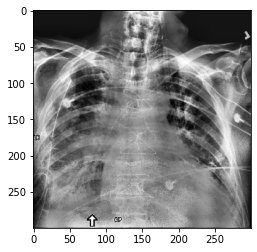

In [ ]:
plt.imshow(np.array(inspect[0][0]))

In [ ]:
inspect

[(array([[[0.07843138, 0.07843138, 0.07843138],
          [0.07843138, 0.07843138, 0.07843138],
          [0.07843138, 0.07843138, 0.07843138],
          ...,
          [0.07843138, 0.07843138, 0.07843138],
          [0.07843138, 0.07843138, 0.07843138],
          [0.07843138, 0.07843138, 0.07843138]],
  
         [[0.07843138, 0.07843138, 0.07843138],
          [0.07843138, 0.07843138, 0.07843138],
          [0.07843138, 0.07843138, 0.07843138],
          ...,
          [0.07843138, 0.07843138, 0.07843138],
          [0.07843138, 0.07843138, 0.07843138],
          [0.07843138, 0.07843138, 0.07843138]],
  
         [[0.07843138, 0.07843138, 0.07843138],
          [0.07843138, 0.07843138, 0.07843138],
          [0.07843138, 0.07843138, 0.07843138],
          ...,
          [0.07843138, 0.07843138, 0.07843138],
          [0.07843138, 0.07843138, 0.07843138],
          [0.07843138, 0.07843138, 0.07843138]],
  
         ...,
  
         [[0.18039216, 0.18039216, 0.18039216],
          [0.1

# Modelling

In [ ]:
def create_model():
    
    #n_labels = 11 # number or output classes
    
    auc = tf.keras.metrics.AUC(multi_label=False) # metric for multi-class multi-label models


    # https://keras.io/api/applications/
    # Options include: ResNet50, MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(300, 300, 3), include_top=False, weights= None
    )

    base_model.trainable = True

    inputs = tf.keras.Input(shape=(300, 300, 3))
    
    # built-in resnet preprocessor
    #https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input 
    
    x = base_model(inputs, training=False)
    

    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # A Dense classifier with a single unit (binary classification)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    #loss=custom_loss_fn,  # Custom Code to apply class weights
    metrics=[auc])


    return model



In [ ]:
my_model_mob = create_model()
print('New model created!')
print()
print(my_model_mob.summary())

New model created!

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_300 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________
None


In [ ]:
history = my_model_mob.fit(
    train_dataset.batch(32),
    epochs=5,
    steps_per_epoch=1000,
    
)

Epoch 1/5
753/753 [==============================] - 707s 928ms/step - loss: -1.0894 - auc: 0.5086
Epoch 2/5
121/753 [===>..........................] - ETA: 9:49 - loss: -1.4652 - auc: 0.5000

KeyboardInterrupt: ignored

In [ ]:
history_b3 = my_model_effb3.fit(
    train_dataset.batch(64),
    epochs=5
)

Epoch 1/5


ResourceExhaustedError: ignored

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [ ]:
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

RuntimeError: ignored

In [ ]:
plt.imshow(inspect[0][0].squeeze())

In [ ]:
my_model_mob.save_weights('weight_mob_61.h5')

NameError: ignored

# Unet architecture